In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.2 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from catboost import Pool
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Final_df.csv')

In [ ]:
# 전처리

df_900 = df[df['duration'] >= 900]
df_900 = df_900[df_900['red_gold_perM'] != 0]
df_900.reset_index(drop=True, inplace=True)

In [ ]:
df_900

,blue_baron_first,blue_champion_first,blue_dragon_first,blue_inhibitor_first,blue_riftherald_first,blue_tower_first,blue_win,red_baron_first,red_champion_first,red_dragon_first,...,red_damage,blue_jungle_minion,red_jungle_minion,blue_total_minion,red_total_minion,blue_death_time,red_death_time,blue_visionscore,red_visionscore,win
0,0,0,0,0,0,0,0,0,1,1,...,8244.6,4,27,333,452,358,66,54,78,0
1,0,0,0,0,1,0,0,1,1,1,...,15635.2,12,45,552,581,833,318,127,153,0
2,1,0,1,1,1,1,1,0,1,0,...,10214.8,22,6,548,580,326,652,138,93,1
3,0,1,1,1,1,0,0,1,0,0,...,30668.8,34,19,865,911,1344,1575,288,259,0
4,1,0,0,1,1,1,1,0,1,1,...,22866.0,69,0,653,576,998,992,196,127,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93298,0,1,0,0,0,0,0,0,0,1,...,7752.0,0,10,366,395,372,119,52,72,0
93299,0,0,1,0,1,1,1,0,1,0,...,3533.6,8,0,442,323,66,275,85,38,0
93300,0,1,0,1,0,1,1,0,0,1,...,8992.6,10,8,589,494,313,674,119,113,0
93301,0,1,0,0,0,1,0,1,0,1,...,14072.4,15,51,608,631,789,367,104,138,0


In [ ]:
# 새로운 컬럼 생성 (blue가 이기면 1, red가 이기면 0)

df_900['win'] = df['blue_win'].apply(lambda x: 1 if x == 1 else 0)

In [ ]:
# 스플릿

X = df_900.drop(['blue_win', 'red_win', 'win'], axis=1)
y = df_900['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 그리드 서치

RF = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10, 12],
}

grid_search = GridSearchCV(RF, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
# 모델 훈련

RF = RandomForestRegressor(max_depth=8, n_estimators=100)
RF.fit(X_train, y_train)
preds = RF.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, preds)
print("mse:", mse)

mse: 0.24917295341193327


In [ ]:
# Kfold

kf = KFold(n_splits=5, shuffle = True, random_state=42)
score = cross_val_score(RF, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

print("Cross-Validation Mean Accuracy:", score.mean())

Cross-Validation Mean Accuracy: -0.2496341482762761


In [ ]:
# 변수 중요도

importances = RF.feature_importances_

feature_importance = dict(zip(X.columns, importances.tolist()))

feature_importance_top = sorted(feature_importance.items(), key=lambda x:x[1], reverse=True)

feature_importance_top

[('blue_gold_perM', 0.050836281425819065),
 ('red_damage', 0.04935191065920509),
 ('blue_damage', 0.04640205392259955),
 ('blue_total_minion', 0.045472224706038684),
 ('red_gold_perM', 0.043606326366924866),
 ('red_kda', 0.04274277855101509),
 ('blue_kda', 0.042507891491341994),
 ('red_lane_minion', 0.04030165359236017),
 ('blue_death_time', 0.04008850771672518),
 ('blue_lane_minion', 0.0390038367841706),
 ('blue_gold_earned', 0.03892506425698217),
 ('duration', 0.03878578146690547),
 ('red_death_time', 0.036258358887820495),
 ('red_total_minion', 0.035443930598836625),
 ('red_gold_earned', 0.03465563341467654),
 ('blue_visionscore_perM', 0.03458488989988139),
 ('blue_visionscore', 0.032812985427807535),
 ('red_visionscore_perM', 0.03191535760458809),
 ('blue_jungle_minion', 0.031407635866794736),
 ('red_visionscore', 0.03004066520253712),
 ('red_jungle_minion', 0.029902873581597413),
 ('blue_solo_kill', 0.02102267301834162),
 ('red_solo_kill', 0.018713551607714738),
 ('red_level', 0.0

<function matplotlib.pyplot.show(close=None, block=None)>

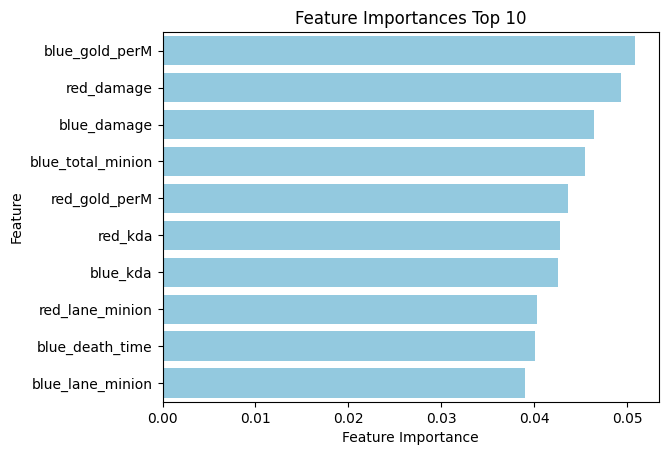

In [ ]:
# 변수 중요도 Top 10

top_features = [feature[0] for feature in feature_importance_top[:10]]
top_importances = [feature[1] for feature in feature_importance_top[:10]]

sns.barplot(x=top_importances, y=top_features, orient="h", color='skyblue')

plt.title('Feature Importances Top 10')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.show()

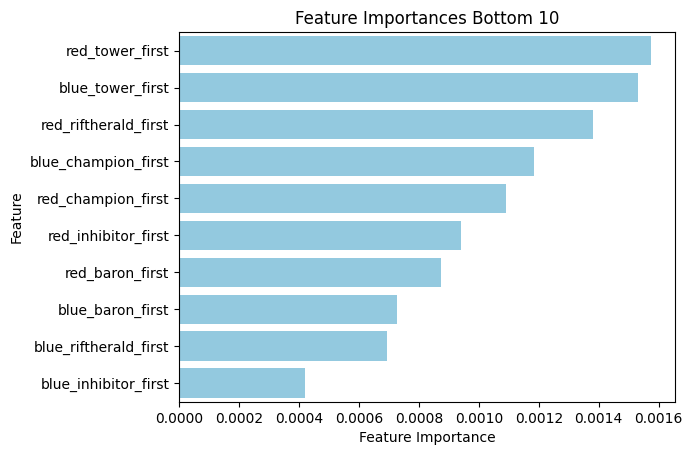

In [ ]:
# 변수 중요도 bottom 10

top_features = [feature[0] for feature in feature_importance_top[-10:]]
top_importances = [feature[1] for feature in feature_importance_top[-10:]]

sns.barplot(x=top_importances, y=top_features, orient="h", color='skyblue')

plt.title('Feature Importances Bottom 10')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.show()

In [ ]:
X.columns

Index(['blue_baron_first', 'blue_champion_first', 'blue_dragon_first',
       'blue_inhibitor_first', 'blue_riftherald_first', 'blue_tower_first',
       'red_baron_first', 'red_champion_first', 'red_dragon_first',
       'red_inhibitor_first', 'red_riftherald_first', 'red_tower_first',
       'blue_baron', 'blue_champion', 'blue_dragon', 'blue_inhibitor',
       'blue_riftherald', 'blue_tower', 'red_baron', 'red_champion',
       'red_dragon', 'red_inhibitor', 'red_riftherald', 'red_tower',
       'blue_lane_minion', 'red_lane_minion', 'blue_lane_gold',
       'red_lane_gold', 'duration', 'blue_gold_perM', 'red_gold_perM',
       'blue_gold_earned', 'red_gold_earned', 'blue_kda', 'red_kda',
       'blue_solo_kill', 'red_solo_kill', 'blue_visionscore_perM',
       'red_visionscore_perM', 'blue_level', 'red_level', 'blue_death',
       'red_death', 'blue_damage', 'red_damage', 'blue_jungle_minion',
       'red_jungle_minion', 'blue_total_minion', 'red_total_minion',
       'blue_death_t